In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim==3.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 47.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.0-cp39-cp39-linux_x86_64.whl size=24952728 sha256=d45c85bb709a4a746d17e21d0b5df5de8e3a5f87e2ad50a1cb2edaccb9b37c62
  Stored in directory: /root/.cache/pip/wheels/fb/18/fa/2a0084905c1be0cead09a515d05015c1f939afb16fd7893ff4
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


In [3]:
from nltk.corpus import stopwords 
from collections import Counter
import nltk
nltk.download('stopwords')
import re
import seaborn as sns
from tqdm import tqdm

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch

# CURRENT_DIR = os.getcwd()
CURRENT_DIR = "/content/drive/MyDrive/CSE582-NLP-Assignment2-986195304"
INPUT_FILE = os.path.join(CURRENT_DIR, 'output','top_data_df_small.csv')
OUTPUT_FOLDER = os.path.join(CURRENT_DIR, 'output')

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
df = pd.read_csv(INPUT_FILE)
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,tokenized_text,stemmed_tokens
0,1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1,"['ve', 'taken', 'lot', 'of', 'spin', 'classes'...","['ve', 'taken', 'lot', 'of', 'spin', 'class', ..."
1,3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1,"['wow', 'yummy', 'different', 'delicious', 'ou...","['wow', 'yummi', 'differ', 'delici', 'our', 'f..."
2,4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1,"['cute', 'interior', 'and', 'owner', 'gave', '...","['cute', 'interior', 'and', 'owner', 'gave', '..."
3,6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1,"['loved', 'this', 'tour', 'grabbed', 'groupon'...","['love', 'thi', 'tour', 'grab', 'groupon', 'an..."
4,7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1,"['amazingly', 'amazing', 'wings', 'and', 'home...","['amazingli', 'amaz', 'wing', 'and', 'homemad'..."


### Splitting to train and test data

We will split data to train and test initially. Doing this on earlier stage allows to avoid data lekage.


In [6]:
X,y = df['text'].values,df['stars'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (15000,)
shape of test data is (5000,)


### Analysing sentiment

### Tokenization

In [7]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received < 3:
        return 0
    # elif stars_received == 3:
    #     return 0
    else:
        return 1

In [8]:
# nltk.download('stopwords')
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [map_sentiment(label) for label in y_train]  
    encoded_test = [map_sentiment(label) for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [9]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
x_val, y_val = x_test[:int(len(x_test)/2)], y_test[:int(len(y_test)/2)]
x_test, y_test = x_test[int(len(x_test)/2):], y_test[int(len(y_test)/2):]

<ipython-input-8-a5aca38cc3cc>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [10]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

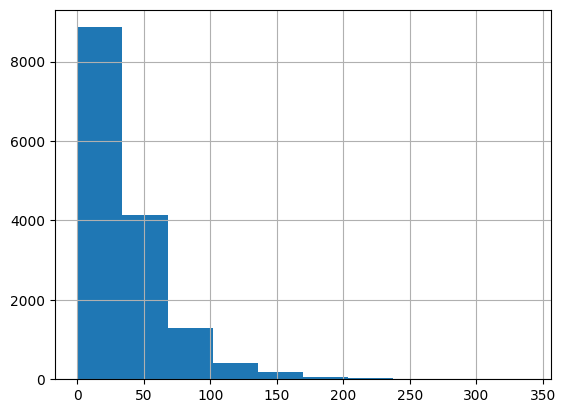

count    15000.000000
mean        37.567267
std         31.945531
min          0.000000
25%         16.000000
50%         28.000000
75%         48.000000
max        339.000000
dtype: float64

In [11]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

Now we will pad each of the sequence to max length 

In [12]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [13]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
x_val_pad = padding_(x_val,500)

### Batching and loading as tensor

In [14]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [15]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 152, 869, 204],
        [  0,   0,   0,  ..., 139, 471,  31],
        [  0,   0,   0,  ...,  32,  12,  11],
        ...,
        [  0,   0,   0,  ..., 120,   8,  61],
        [  0,   0,   0,  ..., 922, 617,   1],
        [  0,   0,   0,  ...,  11, 373, 373]])
Sample input: 
 tensor([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1])


### Model with TanH as Activation

In [ ]:
import gensim
class SentimentLSTM(nn.Module):
    
    def __init__(self, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension
        # self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

         # embedding and LSTM layers
        w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        weights = w2vmodel.wv
        self.n_vocab = len(w2vmodel.wv.vocab)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        # self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward (self, input_words,hidden):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words,hidden)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        lstm_out = self.tanh(lstm_out)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h

    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

              

### Training

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 512

model = SentimentLSTM(embedding_dim, hidden_dim, output_dim, no_layers)

#moving to gpu
model.to(device)

print(model)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

SentimentLSTM(
  (embedding): Embedding(26780, 500, padding_idx=1113)
  (lstm): LSTM(500, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)
Total parameters: 17568433
Trainable parameters: 4178433


In [ ]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
import time
for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
  
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    end_time = time.time()
    print("Epoch : " + str(epoch + 1))
    print(f'Train Loss : {epoch_train_loss}')
    print(f'Val Loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print("Time taken :"+ str(time.time() - start_time))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model, os.path.join(OUTPUT_FOLDER, 'lstm_big_model_500_with_padding_tanh.pth'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch1
Train Loss : 0.6241714019907846
Val Loss : 0.6186119516690572
train_accuracy : 67.13333333333334 val_accuracy : 67.49333333333334
Time taken :108.47029232978821
Validation loss decreased (inf --> 0.618612).  Saving model ...
Epoch2
Train Loss : 0.5358706374300851
Val Loss : 0.49702851454416913
train_accuracy : 73.51111111111112 val_accuracy : 75.81333333333333
Time taken :115.53083443641663
Validation loss decreased (0.618612 --> 0.497029).  Saving model ...
Epoch3
Train Loss : 0.4665369862318039
Val Loss : 0.42883686502774554
train_accuracy : 78.42222222222223 val_accuracy : 80.90666666666667
Time taken :117.02315664291382
Validation loss decreased (0.497029 --> 0.428837).  Saving model ...
Epoch4
Train Loss : 0.4154030047853788
Val Loss : 0.41671433289845783
train_accuracy : 81.20444444444445 val_accuracy : 81.06666666666666
Time taken :117.4318675994873
Validation loss decreased (0.428837 --> 0.416714).  Saving model ...
Epoch5
Train Loss : 0.37957873142427867
Val Loss : 0.39

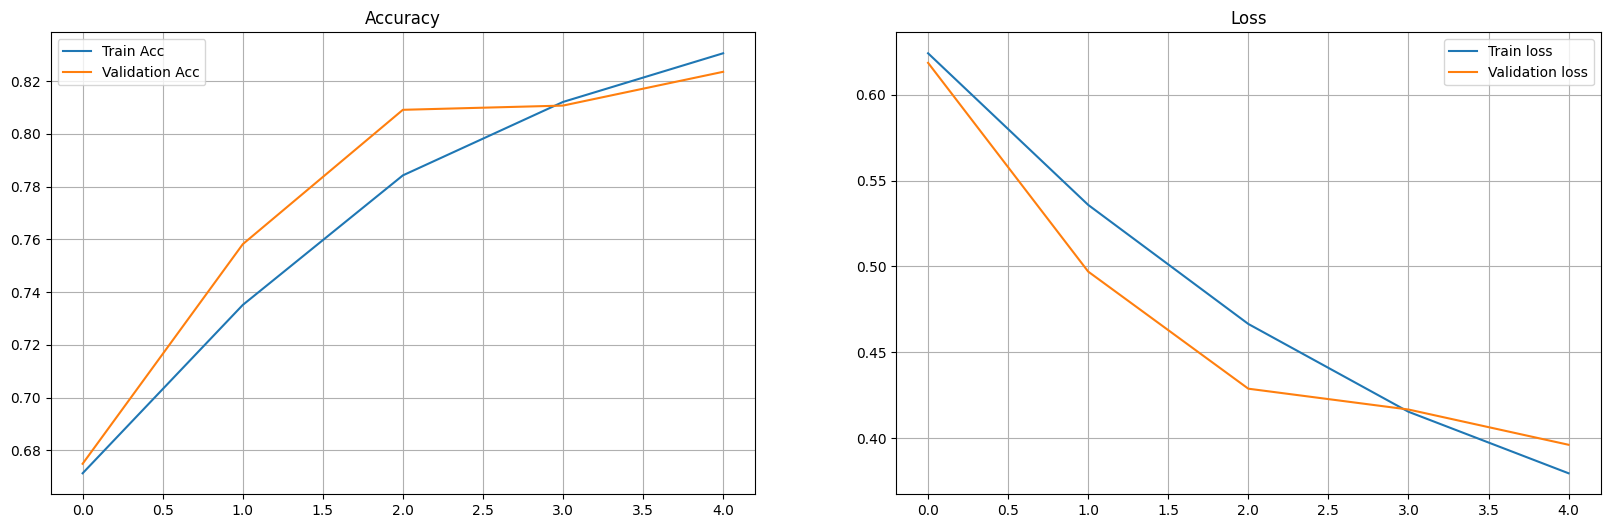

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [ ]:
model.eval()
test_losses = []
num_correct = 0
with torch.no_grad():
  test_h = model.init_hidden(batch_size)
  for index, row in enumerate(test_loader):
          test_h = tuple([each.data for each in test_h])
          inputs, labels = inputs.to(device), labels.to(device)
          output, test_h = model(inputs, test_h)
          predicted = torch.round(output.squeeze())
          loss = criterion((output), (labels).float())
          test_losses.append(loss.item())
          correct_tensor = predicted.eq(labels.float().view_as(predicted))
          correct = np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.3317
Test Accuracy: 0.86


Model with Relu as Activation

In [16]:
import gensim
class SentimentLSTMRelu(nn.Module):
    
    def __init__(self, n_vocab, n_embed, n_hidden, n_output, n_layers, drop_p = 0.5):
        super().__init__()
        # params: "n_" means dimension
        # self.n_vocab = n_vocab     # number of unique words in vocabulary
        self.n_layers = n_layers   # number of LSTM layers 
        self.n_hidden = n_hidden   # number of hidden nodes in LSTM

         # embedding and LSTM layers
        w2vmodel = gensim.models.KeyedVectors.load(os.path.join(OUTPUT_FOLDER, 'models', 'word2vec_500_PAD.model'))
        weights = w2vmodel.wv
        self.n_vocab = len(w2vmodel.wv.vocab)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        
        # self.embedding = nn.Embedding(n_vocab, n_embed)
        self.lstm = nn.LSTM(n_embed, n_hidden, n_layers, batch_first = True, dropout = drop_p)
        self.dropout = nn.Dropout(drop_p)
        self.fc = nn.Linear(n_hidden, n_output)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward (self, input_words, hidden):
                                             # INPUT   :  (batch_size, seq_length)
        embedded_words = self.embedding(input_words)    # (batch_size, seq_length, n_embed)
        lstm_out, h = self.lstm(embedded_words,hidden)         # (batch_size, seq_length, n_hidden)
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.n_hidden) # (batch_size*seq_length, n_hidden)
        lstm_out = self.relu(lstm_out)
        fc_out = self.fc(lstm_out)                      # (batch_size*seq_length, n_output)
        sigmoid_out = self.sigmoid(fc_out)              # (batch_size*seq_length, n_output)
        sigmoid_out = sigmoid_out.view(batch_size, -1)  # (batch_size, seq_length*n_output)
        
        # extract the output of ONLY the LAST output of the LAST element of the sequence
        sigmoid_last = sigmoid_out[:, -1]               # (batch_size, 1)
        
        return sigmoid_last, h

    def init_hidden (self, batch_size):  # initialize hidden weights (h,c) to 0
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        weights = next(self.parameters()).data
        h = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        
        return h

              

In [17]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 500
output_dim = 1
hidden_dim = 512

model_relu = SentimentLSTMRelu(vocab_size, embedding_dim, hidden_dim, output_dim, no_layers)

#moving to gpu
model_relu.to(device)

print(model_relu)

print("Total parameters:", sum(p.numel() for p in model_relu.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model_relu.parameters() if p.requires_grad))

# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model_relu.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

SentimentLSTMRelu(
  (embedding): Embedding(26780, 500, padding_idx=1113)
  (lstm): LSTM(500, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)
Total parameters: 17568433
Trainable parameters: 4178433


In [19]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
import time
for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    train_acc = 0.0
    model_relu.train()
    # initialize hidden state 
    h = model_relu.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model_relu.zero_grad()
        output,h = model_relu(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        train_losses.append(loss.item())
        
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
  
    val_h = model_relu.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model_relu.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model_relu(inputs,val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    end_time = time.time()
    print("Epoch" + str(epoch + 1))
    print(f'Train Loss : {epoch_train_loss}')
    print(f'Val Loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print("Time taken :"+ str(time.time() - start_time))
    if epoch_val_loss <= valid_loss_min:
        torch.save(model_relu, os.path.join(OUTPUT_FOLDER, 'lstm_big_model_500_with_padding_relu.pth'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch1
Train Loss : 0.45797128851215047
Val Loss : 0.4701203054189682
train_accuracy : 77.88666666666667 val_accuracy : 76.0
Time taken :79.4235348701477
Validation loss decreased (inf --> 0.470120).  Saving model ...
Epoch2
Train Loss : 0.4120337765912215
Val Loss : 0.44103628873825074
train_accuracy : 80.79333333333332 val_accuracy : 80.64
Time taken :80.18923234939575
Validation loss decreased (0.470120 --> 0.441036).  Saving model ...
Epoch3
Train Loss : 0.3561581172545751
Val Loss : 0.364717777967453
train_accuracy : 84.45333333333333 val_accuracy : 84.0
Time taken :80.24930191040039
Validation loss decreased (0.441036 --> 0.364718).  Saving model ...
Epoch4
Train Loss : 0.3146703767279784
Val Loss : 0.3379873242974281
train_accuracy : 86.34666666666668 val_accuracy : 84.36
Time taken :80.15194153785706
Validation loss decreased (0.364718 --> 0.337987).  Saving model ...
Epoch5
Train Loss : 0.28963667636116347
Val Loss : 0.3520246770977974
train_accuracy : 87.46000000000001 val_ac

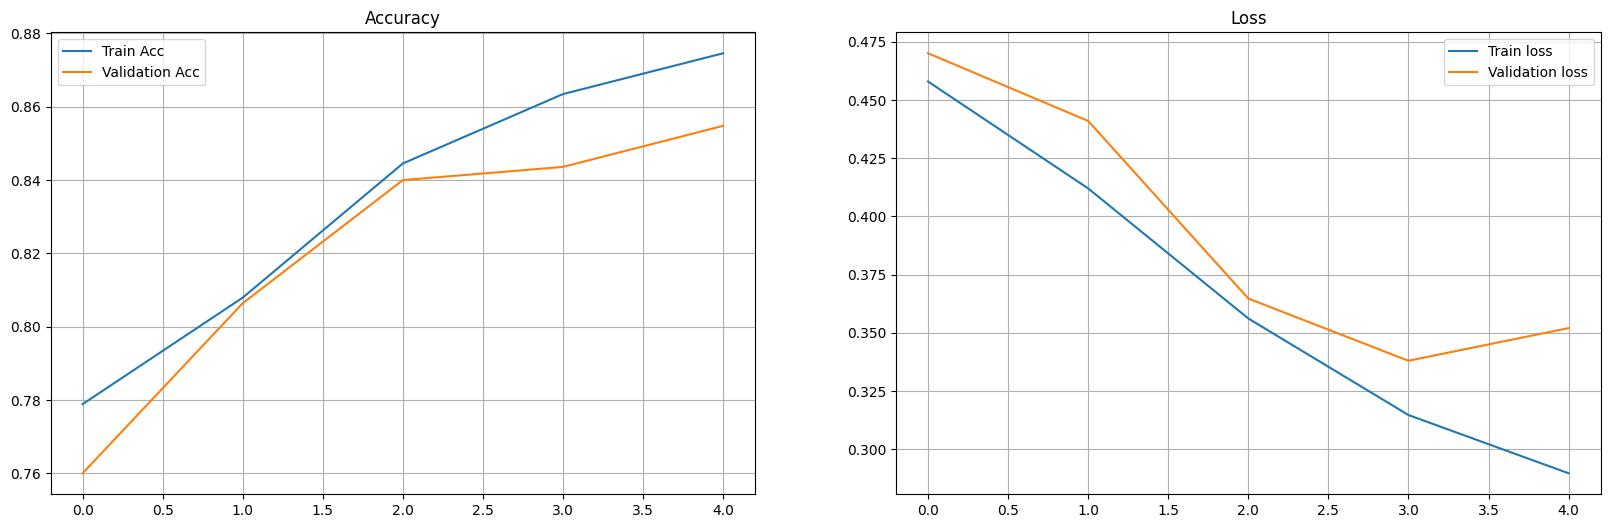

In [20]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [22]:
model_relu.eval()
test_losses = []
num_correct = 0
with torch.no_grad():
  test_h = model_relu.init_hidden(batch_size)
  for index, row in enumerate(test_loader):
          test_h = tuple([each.data for each in test_h])
          inputs, labels = inputs.to(device), labels.to(device)
          output, test_h = model_relu(inputs, test_h)
          predicted = torch.round(output.squeeze())
          loss = criterion((output), (labels).float())
          test_losses.append(loss.item())
          correct_tensor = predicted.eq(labels.float().view_as(predicted))
          correct = np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 0.3891
Test Accuracy: 0.86
